**Professor:** Enrique Garcia Ceja
**email:** enrique.gc@tec.mx

# Exercise: Removing masks from profile pictures using a convolutional autoenconder.

In this exercise you will build an autoencoder to perform a denoising operation. Specifically, removing mask filters from pictures.

<img src="https://github.com/enriquegit/ap-img/blob/main/img/unmask.png?raw=true" width="600">

For this task, you will use a dataset from Tinder profile pictures. A python script was used to apply a dog filter to the pictures. In a previous work, the authors used Generative Adversarial Networks (GANs) to denoise the pictures. [Here](https://github.com/ipsingh06/ml-desnapify) you can find the original code to apply the filters and solve the problem using GANs.

Now, you will explore if it is possible to remove those annoying filters using an autoencoder! Based on training data, the autoencoder will try to 'imagine' what is under the mask and it will try to recreate the original face without filters.


### Instructions to upload dataset

**Note: Before uploading the dataset make sure you have selected the GPU runtime!**

1. Create a folder named "datasets" in the current working directory (same level as the "sample_data" directory).

2. Upload the *sample_faces.zip* (provided by the professor) file in the newely created "datasets" directory. It may take some minutes.

3. Run the following cell to unzip the files.

In [1]:
import os
os.chdir('..')

In [2]:
# This cell is used to unzip the faces dataset.
import zipfile

with zipfile.ZipFile("data/sample_faces.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

In [4]:
# Specify the parent path where the the 'masked' and 'original' pictures are.

rootpath = "data/"

In [5]:
files_original = os.listdir(rootpath + "original/")

files_mask = os.listdir(rootpath + "masked/")

n = 2500 # Number of images to process.

target_size = (200,200) # Image size. For computational reasons, resize the images to 200x200

imgs_original = [] # Original images are stored here.

imgs_mask = [] # Images with mask are stored here.

for i in range(n):
    img = image.load_img(rootpath + "original/" + files_original[i], target_size=target_size)
    img = image.img_to_array(img)
    img = img/255.
    imgs_original.append(img)

    img2 = image.load_img(rootpath + "masked/" + files_mask[i], target_size=target_size)
    img2 = image.img_to_array(img2)
    img2 = img2/255.
    imgs_mask.append(img2)

imgs_original=np.array(imgs_original)

imgs_mask=np.array(imgs_mask)

# shuffle images
n = imgs_original.shape[0]
np.random.seed(123)
idxs = np.random.choice(n, size=n, replace=False)
imgs_original = imgs_original[idxs,:,:,:]
imgs_mask = imgs_mask[idxs,:,:,:]

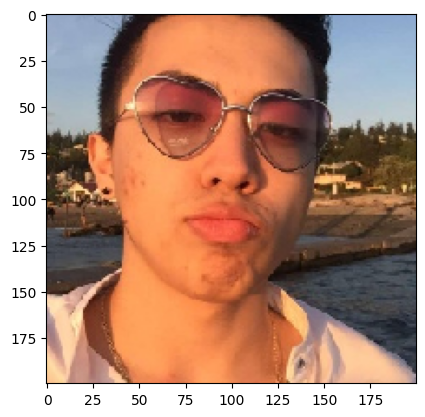

In [6]:
selected = 55 # Select an image to display.

plt.imshow(imgs_original[selected,])

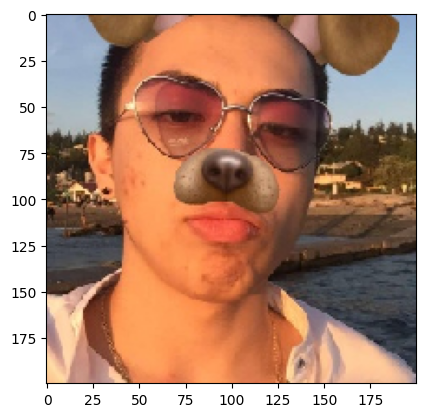

In [7]:
# Display same image but with filter applied.

plt.imshow(imgs_mask[selected,])

In [14]:
# Select some test images.

n_test = 100 # number of images to use as test set

# This is the training set.
train_orig = imgs_original[n_test:,:,:,:]
train_mask = imgs_mask[n_test:,:,:,:]

# This is the test set.
test_orig = imgs_original[0:n_test,:,:,:]
test_mask = imgs_mask[0:n_test,:,:,:]

`train_orig` and `train_mask` contain the train set images with and without masks.

`test_orig` and `test_mask` contain the test set images with and without masks.


### Now, it is time to define the convolutional autoencoder. Since the purpose of this model is not to compress data but to denoise, it is not necessary for the 'middle layer' to be very small.

In [19]:
print(train_orig.shape)

(2400, 200, 200, 3)


In [46]:
# Define your convolutional autoencoder and name it 'autoencoder'.
# YOUR CODE HERE.

input_img = Input(shape=(200, 200, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

# This time we will use the Adam optimizer instead of SGD
# which uses momentum.
opt = optimizers.Adam()

# Compile the model.
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

# Print a summary of the model.
print(autoencoder.summary())

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 200, 200, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 100, 100, 20)   │         2,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 50, 50, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 50, 50, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_35 (UpSampling2D) │ (None, 100, 100, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 100, 100, 16)   │         2,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_36 (UpSampling2D) │ (None, 200, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 200, 200, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,299 (40.23 KB)

 Trainable params: 10,299 (40.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
# Train the autoencoder with the fit function. The inputs are the images with mask and the predicted images
# are the ones without masks.
# YOUR CODE HERE.   

autoencoder.fit(train_mask, train_orig,
                epochs=50,
                batch_size=20,
                shuffle=True,
                validation_split=0.15)


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 599ms/step - loss: 0.5633 - val_loss: 0.5250
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - loss: 0.5111 - val_loss: 0.5172
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - loss: 0.5074 - val_loss: 0.5150
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - loss: 0.5057 - val_loss: 0.5136
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - loss: 0.5038 - val_loss: 0.5129
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - loss: 0.5028 - val_loss: 0.5119
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - loss: 0.5018 - val_loss: 0.5107
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - loss: 0.5011 - val_loss: 0.5110
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - loss: 0.5006 - val_loss: 0.5097
Epoch 10/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - loss: 0.5001 - val_loss: 0.5090
Epoch 11/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - loss: 0.4998 - val_loss: 0.5091
Epoch 12/50
102/102

In [52]:
autoencoder.save("model/autoencoder1.keras")
autoencoder = load_model("model/autoencoder1.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


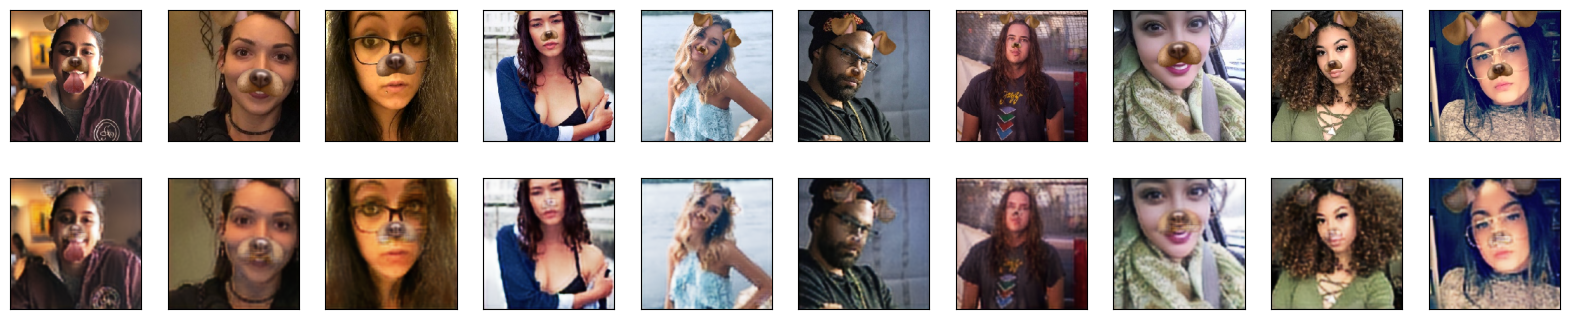

In [48]:
# Let's display the masked images (first n) and the predicted denoised images (bottom).

# Number of images to display from training set
n = 10

decoded_imgs = autoencoder.predict(train_mask[1:n+1,])

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_mask[i+1].reshape(train_orig.shape[1], train_orig.shape[2], train_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(train_orig.shape[1], train_orig.shape[2], train_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


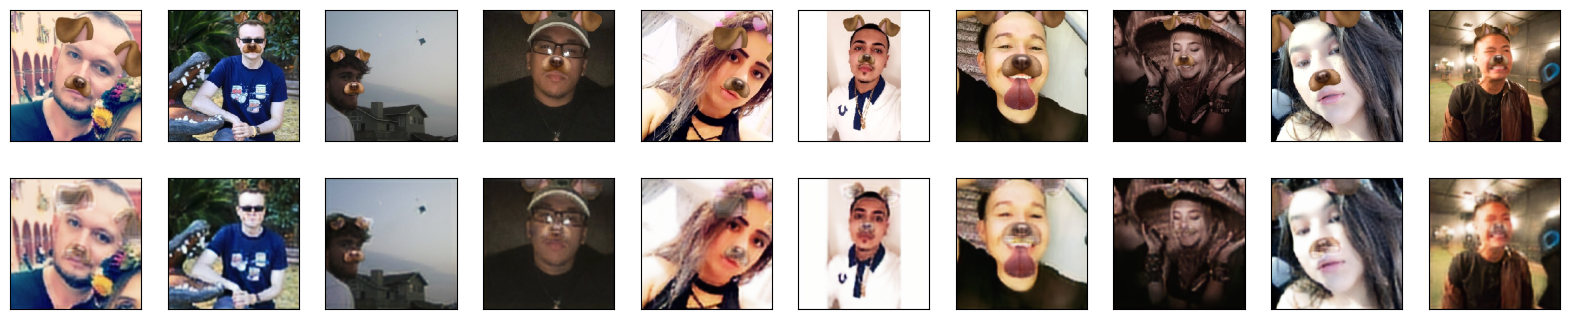

In [49]:
# Now lets try the autoencoder on the test set!

startpos = 0 # start position. Try different start positions: 10, 20, 30, etc.

n = 10 # # number of images to show begining at startpos.

decoded_imgs = autoencoder.predict(test_mask[startpos:startpos+n,])

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_mask[i+startpos].reshape(test_orig.shape[1], test_orig.shape[2], test_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(test_orig.shape[1], test_orig.shape[2], test_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()